<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/transform_datacube_to_dssat_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Export historical weather and soil data using soil categories

In this workflow, we aim to export combined weather and soil data based on specific soil layer categories, such as soil texture. By aligning both data cubes (weather and soil) to the same projection and spatial resolution, we ensure that the exported data is consistent and ready for analysis. To use this code it is first neccesary to download th weather and soil data. The following code shows how to achieve this:

#### clone repository

In [1]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

Cloning into 'WeatherSoilDataProcessor'...
remote: Enumerating objects: 1508, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1508 (delta 1), reused 5 (delta 1), pack-reused 1499 (from 1)
Receiving objects: 100% (1508/1508), 120.30 MiB | 15.13 MiB/s, done.
Resolving deltas: 100% (1341/1341), done.
Updating files: 100% (431/431), done.


#### install requirements

In [1]:
!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

In [2]:
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

os.chdir('/content/WeatherSoilDataProcessor')

In [9]:
from spatialdata.climate_data import MLTWeatherDataCube
from spatialdata.files_manager import IntervalFolderManager, SoilFolderManager
from spatialdata.gis_functions import get_boundaries_from_path, reproject_xrdata, re_scale_xarray, resample_xarray, add_2dlayer_toxarrayr
from spatialdata.plt_funs import plot_datacube
from spatialdata.soil_data import SoilDataCube, find_soil_textural_class_in_nparray

import numpy as np


## Creating datacubes

First, we will generate two data cubes: one for weather data and another for soil data. Data cubes organize multi-dimensional arrays (For weather, the dimensions are time, wehater variable, latitude and latitude; while for soil, the dimensions are depth, soil property, latitude, and longitude).

In [4]:
extent = get_boundaries_from_path('data/country.shp', round_numbers = True)

# Specify paths for weather data, such as precipitation and solar radiation
list_weather_paths = {'precipitation': 'weather/precipitation_hnd_raw',
                    'srad': 'weather/solar_radiation_hnd_raw',
                    'tmax': 'weather/temperature_tmax_hnd_raw',
                    'tmin': 'weather/temperature_tmin_hnd_raw'}

starting_date, ending_date = '2001-01-01', '2001-12-31'


wdatacube = MLTWeatherDataCube(list_weather_paths, IntervalFolderManager(), extent=extent)

filenames = wdatacube.common_dates_and_file_names(starting_date=starting_date, ending_date=ending_date)
weather_datacube = wdatacube.multitemporal_data(reference_variable='precipitation', ncores=0)


weather/precipitation_hnd_raw/2001
weather/solar_radiation_hnd_raw/2001
weather/temperature_tmax_hnd_raw/2001
weather/temperature_tmin_hnd_raw/2001


100%|██████████| 365/365 [00:56<00:00,  6.44it/s]


Next, we create the soil data cube

In [5]:
paths = 'soil/hnd'

gfd = gpd.read_file('data/country.shp')
gfd = gfd.to_crs('ESRI:54052')
extent = gfd.total_bounds

folder_manager = SoilFolderManager(paths, ["bdod", "clay",  "sand", "silt","wv0033", "wv1500"])
soilcube = SoilDataCube(folder_manager)
soil_datacube = soilcube.multi_depth_data(verbose=False, reference_variable='sand')

  0%|          | 0/4 [00:00<?, ?it/s]

{'bdod': 'soil/hnd/bdod_0-5cm_mean_30s.tif', 'clay': 'soil/hnd/clay_0-5cm_mean_30s.tif', 'sand': 'soil/hnd/sand_0-5cm_mean_30s.tif', 'silt': 'soil/hnd/silt_0-5cm_mean_30s.tif', 'wv0033': 'soil/hnd/wv0033_0-5cm_mean.tif', 'wv1500': 'soil/hnd/wv1500_0-5cm_mean.tif'}
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


 25%|██▌       | 1/4 [00:13<00:40, 13.62s/it]

{'bdod': 'soil/hnd/bdod_5-15cm_mean_30s.tif', 'clay': 'soil/hnd/clay_5-15cm_mean_30s.tif', 'sand': 'soil/hnd/sand_5-15cm_mean_30s.tif', 'silt': 'soil/hnd/silt_5-15cm_mean_30s.tif', 'wv0033': 'soil/hnd/wv0033_5-15cm_mean.tif', 'wv1500': 'soil/hnd/wv1500_5-15cm_mean.tif'}
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


 50%|█████     | 2/4 [00:27<00:27, 13.54s/it]

{'bdod': 'soil/hnd/bdod_15-30cm_mean_30s.tif', 'clay': 'soil/hnd/clay_15-30cm_mean_30s.tif', 'sand': 'soil/hnd/sand_15-30cm_mean_30s.tif', 'silt': 'soil/hnd/silt_15-30cm_mean_30s.tif', 'wv0033': 'soil/hnd/wv0033_15-30cm_mean.tif', 'wv1500': 'soil/hnd/wv1500_15-30cm_mean.tif'}
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


 75%|███████▌  | 3/4 [00:40<00:13, 13.44s/it]

{'bdod': 'soil/hnd/bdod_30-60cm_mean_30s.tif', 'clay': 'soil/hnd/clay_30-60cm_mean_30s.tif', 'sand': 'soil/hnd/sand_30-60cm_mean_30s.tif', 'silt': 'soil/hnd/silt_30-60cm_mean_30s.tif', 'wv0033': 'soil/hnd/wv0033_30-60cm_mean.tif', 'wv1500': 'soil/hnd/wv1500_30-60cm_mean.tif'}
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


100%|██████████| 4/4 [00:53<00:00, 13.40s/it]


## Reproject to a Common Coordinate Reference System (CRS)

Both weather and soil data must have the same projection to ensure spatial alignment. Here, we reproject the soil data to match the weather data in the common CRS (Coordinate Reference System), for this example will be WGS84 (epsg:4326).

In [6]:
## crs
crs = 'EPSG:4326'

weather_datacube = {k: reproject_xrdata(v,target_crs=crs) for k, v in weather_datacube.items()}
soil_datacube = {k: reproject_xrdata(v,target_crs=crs) for k, v in soil_datacube.items()}


## Extracting data for a specific region

In this part of the analysis, we focus on extracting weather and soil data for a specific location—typically at the level of an administrative division, such as a district or municipality. By focusing on a specific region, we can obtain more detailed and relevant insights, particularly in terms of climate and soil characteristics that may impact agriculture, agronomic management, or other land-use practices.

### Selection of the region of interest (ROI)
We begin by defining the boundary for the specific location, often using geographic data from administrative boundary shapefiles.

In [7]:
gdf = gpd.read_file('data/tb_limitealdeas.shp')
locality = 'Río Plátano'
subset = gdf.loc[gdf['ALDEA'] == locality]
subset

,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
59,090212,Río Plátano,090212,0902,09,265.946,4.45578,Brus Laguna,Gracias a Dios,26594.643479,"POLYGON ((-84.75784 15.88288, -84.7481 15.8826..."


### Masking Data to the ROI:
Once the region is defined, the weather and soil data are "masked," meaning that the datacubes are filtered to only include values within the selected boundaries.

In [8]:
soil_datacube_m = soilcube.mask_mldata(soil_datacube,subset.geometry)
weather_datacube_m = wdatacube.mask_mldata(weather_datacube,subset.geometry, ncores=0)

100%|██████████| 365/365 [00:58<00:00,  6.26it/s]


### Combining Weather and Soil Data
#### Rescale Soil and Weather Data Cubes

Since weather data and soil data might have different spatial resolutions, we need to rescale them so that they can be stacked and analyzed together. This step ensures that both datasets align perfectly.
We first rescale the weather data and then use this rescaled version as a reference for adjusting the soil data resolution.
- **Weather Rescaling:** The weather data cube is upscaling using a scale factor. The method employed for downscaling is nearest neighbor resampling, which assigns the nearest pixel value to the new grid cells. This is an efficient approach that preserves the original data patterns and avoids interpolation approaches.
- **Soil Rescaling:** After upscaling the weather data, we use it as a reference to rescale the soil data. In this case, the soil data is downscaled to match the resolution of the rescaled weather data. The same nearest neighbor resampling method is applied, ensuring the soil data aligns spatially with the weather data.

In [10]:

scale_factor = 10 ## factor for dowsampling

# weaather rescale
weather_datacube_r = {}
for k,v in tqdm(weather_datacube_m.items()):
    weather_datacube_r[k] = re_scale_xarray(v, scale_factor= scale_factor)

# soil rescale
xr_reference = weather_datacube_r[list(weather_datacube_r.keys())[0]]

soil_datacube_r = {}
for k,v in tqdm(soil_datacube_m.items()):
    soil_datacube_r[k] = resample_xarray(v, xrreference=xr_reference)

100%|██████████| 4/4 [00:00<00:00, 103.94it/s]


Text(0.5, 1.0, 'solar radiation rescaled')

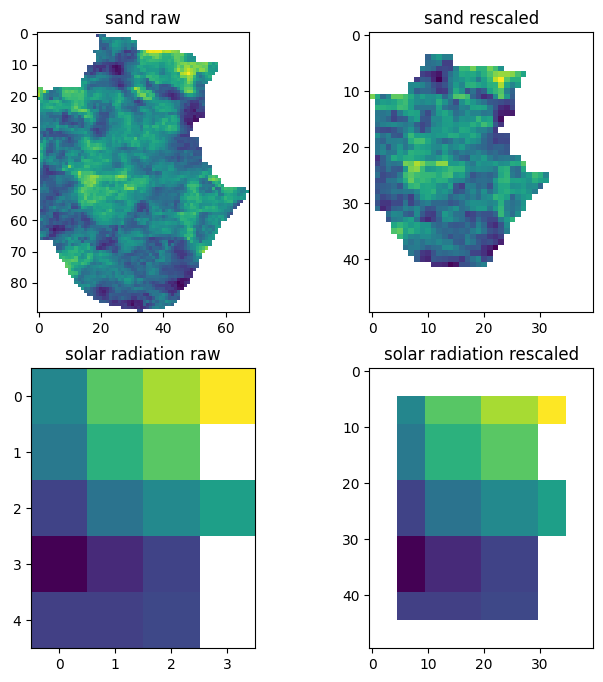

In [11]:
## plots
f, ax = plt.subplots(nrows = 2, ncols= 2, figsize = (8,8))
date = list(weather_datacube_r.keys())[0]

ax[0,0].imshow(soil_datacube_m['0-5'].clay.values)
ax[0,0].set_title('sand raw')
ax[0,1].imshow(soil_datacube_r['0-5'].clay.values)
ax[0,1].set_title('sand rescaled')

ax[1,0].imshow(weather_datacube_m[date].srad.values)
ax[1,0].set_title('solar radiation raw')
ax[1,1].imshow(weather_datacube_r[date].srad.values)
ax[1,1].set_title('solar radiation rescaled')

### Summarizing the weather and soil data using a category
#### Soil texture classification

Soil texture is based on the percentage of sand, clay, and silt.  Soil texture plays a significant role in agriculture, influencing water retention, nutrient availability, and crop suitability.
In this step, we will integrate soil texture classification into our datacube. This allows us to summarize the weather and soil conditions according to different soil texture classes, providing insights that are highly relevant for crop planning and land management

In [12]:
#### Adding Texture to the Data Cube:

soil_datacube_rmrt = {}

for k,v in soil_datacube_r.items():

    sand = v.sand.values*0.1 if np.nanmax(v.sand.values) > 300 else v.sand.values
    clay = v.clay.values*0.1 if np.nanmax(v.clay.values) > 300 else v.clay.values

    texturemap = find_soil_textural_class_in_nparray(sand, clay).astype(float)
    texturemap[texturemap == 0] = np.nan

    soil_datacube_rmrt[k] = add_2dlayer_toxarrayr(texturemap, v, variable_name='texture')

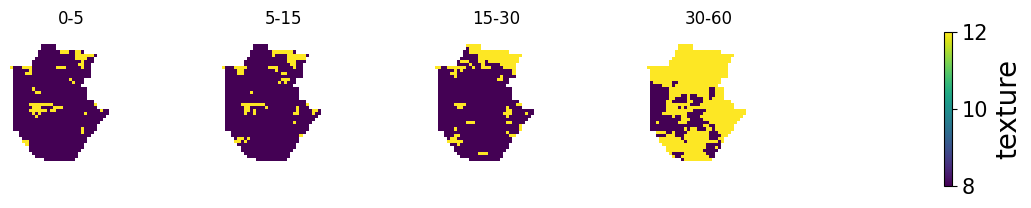

In [13]:
f,a = plot_datacube(soil_datacube_rmrt,dates=False, variable='texture', limit= 4, ncols=4, nrows=1, figsize = (15,2), invertaxis = False, label_name ='texture', legfontsize = 20)

#### Summarizing Data by Soil Texture:
we summarize the weather data for each soil texture category. This step helps to understand how different soil types respond to weather conditions over time.

In [14]:
from spatialdata.soil_data import TEXTURE_CLASSES
import xarray
from datetime import datetime
soilref = soil_datacube_rmrt['0-5']

# getting datavars
weatherdatavars = list(weather_datacube_r[list(weather_datacube_r.keys())[0]].data_vars.keys())

weather_datacube_mrs = []
for k,v in tqdm(weather_datacube_r.items()):
    xrtemp = xarray.merge([v,soilref])[weatherdatavars+ ['texture']]
    xrtemp = xrtemp.expand_dims(dim = ['date'])
    xrtemp['date'] = [k]
    weather_datacube_mrs.append(xrtemp)
weather_datacube_mrs = xarray.concat(weather_datacube_mrs, dim = 'date')

weather_datacube_mrs['date'] = [datetime.strptime(i, "%Y%m%d") for i in list(weather_datacube_r.keys())]

100%|██████████| 365/365 [00:00<00:00, 381.16it/s]


#### Exporting weather data per texture as CSV and DSSAT format files
Once we've combined and summarized the weather and soil data by texture categories, the next step is to export this data for further analysis. We can export the weather data for each soil texture both as CSV files and in DSSAT format, which is widely used in agricultural modeling.

In [24]:
from spatialdata.soil_data import TEXTURE_CLASSES
from crop_modeling.dssat_transform import from_weather_to_dssat, check_weatherxr_scales, DSSATSoil_fromSOILGRIDS
from crop_modeling.dssat_transform import from_soil_to_dssat, get_variables_to_summarize

import copy


In [16]:

params_df_names = {
    "DATE": "date",
    "TMIN": "tmin",
    "SRAD": "srad",
    "RAIN": "precipitation",
    "TMAX": "tmax",
    "LON": "x",
    "LAT": "y"
}

from_weather_to_dssat(copy.deepcopy(weather_datacube_mrs), date_name = 'date', groupby = 'texture', params_df_names=params_df_names,outputpath='tmp', outputfn = 'WHTEL1', codes=TEXTURE_CLASSES)


100%|██████████| 365/365 [00:02<00:00, 161.33it/s]


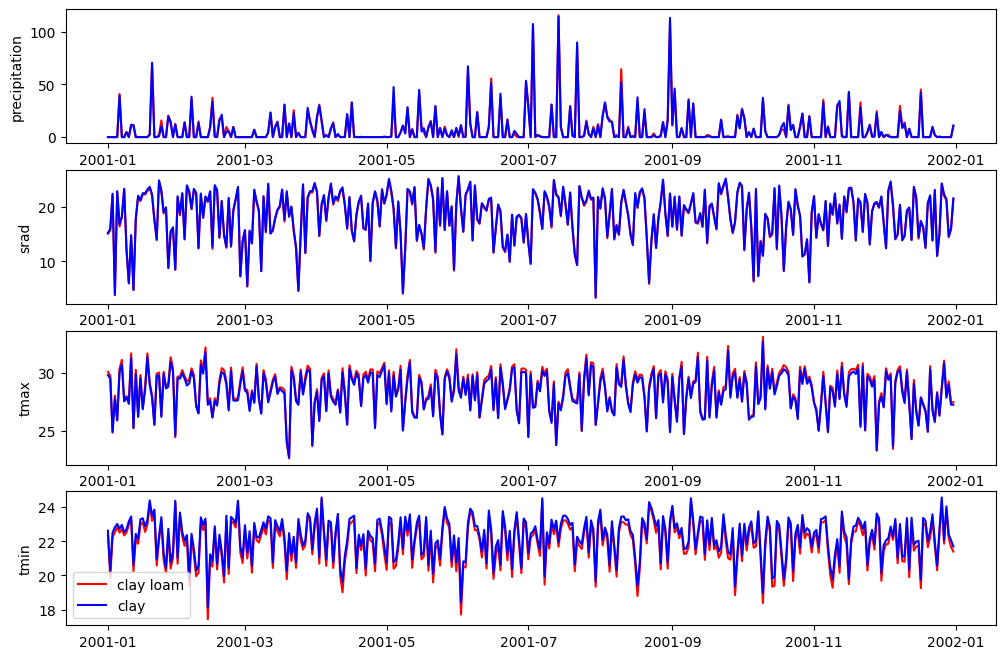

In [17]:

vars_metric = {}

for i in weather_datacube_mrs.data_vars.keys():
    vars_metric.update({i: 'mean'})
vars_metric.pop('texture')


df = check_weatherxr_scales(weather_datacube_mrs).to_dataframe().dropna().reset_index().groupby(['texture','date']).agg(vars_metric).reset_index()

s={8:'r',12:'b'}
f, a =plt.subplots(nrows = 4,ncols = 1, figsize = (12,8))
for idx,grp in df.groupby(['texture']):
    for i,var in enumerate(vars_metric.keys()):
        a[i].plot(grp.date.values, grp[var].values, c=s[int(grp['texture'].values[0])], label = TEXTURE_CLASSES[int(grp['texture'].values[0])])
        a[i].set_ylabel(var)
plt.legend()

In [18]:
### export as nc

weather_datacube_mrs.to_netcdf('tmp/weather.nc')

In [19]:
### export as csv
df.to_csv('tmp/weather.csv')

#### Exporting soil data per texture as CSV and DSSAT format files

In addition to weather data, soil data can also be exported for further analysis.


In [20]:


soil_datacube_mrs = []
for ks, vs in soil_datacube_rmrt.items():
    xrtemp = vs.expand_dims(dim = ['depth'])
    xrtemp['depth'] = [ks]
    soil_datacube_mrs.append(xrtemp)

soil_datacube_mrs = xarray.concat(soil_datacube_mrs, dim = 'depth')

In [21]:
soil_df = from_soil_to_dssat(soil_datacube_mrs, groupby='texture', outputpath='tmp', outputfn='SOILL1', codes=TEXTURE_CLASSES)


In [25]:
DSSATSoil_fromSOILGRIDS.GENERAL_DESCRIPTION

{'SLLL': 'Lower limit of plant extractable soil water, cm3 cm-3',
 'SDUL': 'Drained upper limit, cm3 cm-3',
 'SSAT': 'Upper limit, saturated, cm3 cm-3',
 'SRGF': 'Root growth factor, soil only, 0.0 to 1.0',
 'SBDM': 'Bulk density, moist, g cm-3',
 'SLOC': 'Organic carbon, %',
 'SLCL': 'Clay (<0.002 mm), %',
 'SLSI': 'Silt (0.05 to 0.002 mm), %',
 'SLCF': 'Coarse fraction (>2 mm), %',
 'SLNI': 'Total nitrogen, %',
 'SLHW': 'Soil pH',
 'SMHB': 'pH in buffer determination method, code',
 'SCEC': 'Cation exchange capacity, cmol kg-1',
 'SADC': 'Anion adsorption coefficient, cm3 (H2O) g [soil]-1',
 'SSKS': 'Saturated hydraulic conductivity, macropore, cm h-1'}

In [26]:
soil_df.to_csv('tmp/soil.csv')